In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Mevcut Input Dizini Kontrolü

Bu adımda Kaggle ortamındaki `input` klasörlerinin listesi alınır.  
Hangi veri setlerinin yüklü olduğunu doğrulamak için kullanılır.


In [1]:
import os
print(os.listdir("/kaggle/input"))

['microsoft-catsvsdogs-dataset']


# Veri Seti Kontrolü

Bu adımda veri setinin klasör yapısı kontrol edilir.  
`PetImages` dizini içinde **Cat** ve **Dog** klasörlerinin bulunduğu doğrulanır.


In [2]:
import os

# Çalışma dizini
working_dir = "/kaggle/working/"

# Dataset klasörü (zaten açılmış klasör)
data_dir = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages"

# İçindekileri kontrol et
# Bu adım, Cat ve Dog klasörlerinin mevcut olduğunu doğrular
print(os.listdir(data_dir))

['Dog', 'Cat']


# Eğitim ve Doğrulama Generatorları

Bu bölümde kedi ve köpek veri seti için **ImageDataGenerator** kullanılarak eğitim ve doğrulama generatorları hazırlanmıştır:

- Tüm resimler **[0,1] aralığında normalize** edilmiştir (`rescale=1./255`).  
- Veri seti `%80 eğitim`, `%20 doğrulama` olacak şekilde bölünmüştür (`validation_split=0.2`).  
- `flow_from_directory` ile sınıflar otomatik olarak etiketlenir.  
- `subset='training'` veya `'validation'` parametresi ile generatorların hangi bölüm için çalışacağı belirtilir.


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Veri üreticiler
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Train generator
train_generator = train_datagen.flow_from_directory(data_dir, target_size=(150,150), batch_size=32, class_mode='binary', subset='training')

# Validation generator
val_generator = train_datagen.flow_from_directory(data_dir, target_size=(150,150), batch_size=32, class_mode='binary', subset='validation')

2025-09-26 14:11:15.874351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758895876.056053      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758895876.111783      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# Veri Ön İşleme ve ImageDataGenerator

Bu bölümde kedi ve köpek verisi için eğitim ve doğrulama setleri hazırlanmıştır:  

- **ImageDataGenerator** ile resimler normalize edilmiştir (`rescale=1./255`).  
- Eğitim setine veri artırma (augmentation) uygulanmıştır: yatay çevirme (`horizontal_flip`) ve yakınlaştırma (`zoom_range`).  
- Veri seti %80 eğitim, %20 doğrulama olacak şekilde ayrılmıştır (`validation_split=0.2`).  
- Bozuk veya okunamayan resimler, `valid_image_generator` fonksiyonu ile atlanmıştır.


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import os

# Dataset dizini
data_dir = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages"

# ImageDataGenerator ile eğitim ve doğrulama setlerini oluştur
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # %20 doğrulama
    horizontal_flip=True,
    zoom_range=0.2
)

# Geçerli resimleri kontrol eden fonksiyon
def valid_image_generator(folder, subset='training'):
    for class_name in ['Cat', 'Dog']:
        class_path = os.path.join(folder, class_name)
        for fname in os.listdir(class_path):
            file_path = os.path.join(class_path, fname)
            try:
                load_img(file_path)  # Sadece okunabilen resimleri kullan
                yield file_path, class_name
            except:
                # Bozuk resimleri atla
                pass

# Eğitim generator
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'  # eğitim verisi
)

# Doğrulama generator
val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # doğrulama verisi
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# Model Eğitimi (Binary Classification)

Bu bölümde **CNN (Convolutional Neural Network)** kullanılarak kedi ve köpek sınıflandırması için model oluşturulmuş ve eğitilmiştir.  
- Modelde üç adet Conv2D + MaxPooling katmanı kullanılmıştır.  
- Flatten ve Dense katmanları ile sınıflandırma yapılmıştır.  
- Çıkış katmanı sigmoid aktivasyon ile binary sınıflandırma için yapılandırılmıştır.  
- Model, `binary_crossentropy` loss ve `Adam` optimizer ile compile edilmiştir.  
- Eğitim sırasında bozuk veya okunamayan resimleri atlamak için `safe_generator` fonksiyonu kullanılmıştır.
- Eğitim ve validation sonuçları grafiklerle görselleştirilmiştir.


Epoch 1/5


I0000 00:00:1758896221.817374     138 service.cc:148] XLA service 0x7d2328006460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758896221.818086     138 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758896221.818105     138 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758896222.161106     138 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/625 ━━━━━━━━━━━━━━━━━━━━ 59:33 6s/step - accuracy: 0.5312 - loss: 0.6878

I0000 00:00:1758896225.440780     138 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


364/625 ━━━━━━━━━━━━━━━━━━━━ 1:12 277ms/step - accuracy: 0.5443 - loss: 0.8008

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 229s 358ms/step - accuracy: 0.5652 - loss: 0.7516 - val_accuracy: 0.6410 - val_loss: 0.6269
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 152s 243ms/step - accuracy: 0.6778 - loss: 0.6044 - val_accuracy: 0.7268 - val_loss: 0.5362
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 151s 242ms/step - accuracy: 0.7350 - loss: 0.5243 - val_accuracy: 0.7474 - val_loss: 0.5095
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 150s 240ms/step - accuracy: 0.7824 - loss: 0.4597 - val_accuracy: 0.8084 - val_loss: 0.4270
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 150s 241ms/step - accuracy: 0.8076 - loss: 0.4166 - val_accuracy: 0.8208 - val_loss: 0.3930


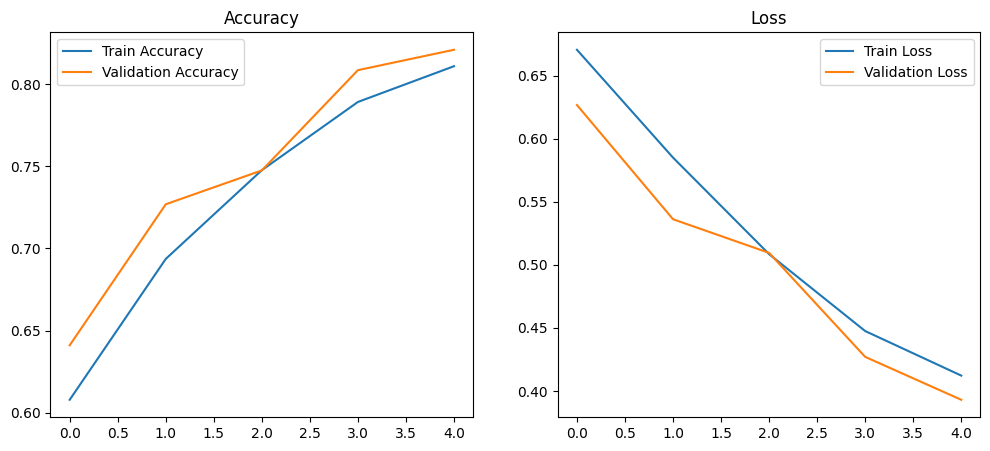

In [6]:
# Model Eğitimi (Binary Classification)

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Modeli yeniden oluştur
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # binary output
])

# Modeli compile et
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',   # binary classification için
    metrics=['accuracy']
)

# Güvenli generator fonksiyonu (bozuk dosyalar için)
def safe_generator(generator):
    while True:
        try:
            yield next(generator)
        except:
            continue  # hata varsa atla

# Modeli eğit
history = model.fit(
    safe_generator(train_generator),
    validation_data=safe_generator(val_generator),
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    epochs=5  # istersen arttırabilirsin
)

# Eğitim ve doğrulama grafiklerini çiz
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Confusion Matrix ve Classification Report

Validation set üzerinde modelin performansını değerlendirmek için **Confusion Matrix** ve **Classification Report** oluşturulmuştur.  

- Confusion Matrix, modelin hangi sınıflarda doğru veya yanlış tahmin yaptığını görselleştirir.  
- Classification Report, her sınıf için precision, recall ve F1-score değerlerini sunar.  
- Tahminler alınırken bozuk veya okunamayan resimler atlanmıştır, böylece performans değerlendirmesi daha güvenilir hâle getirilmiştir.


Bozuk resim atlandı: batch 44


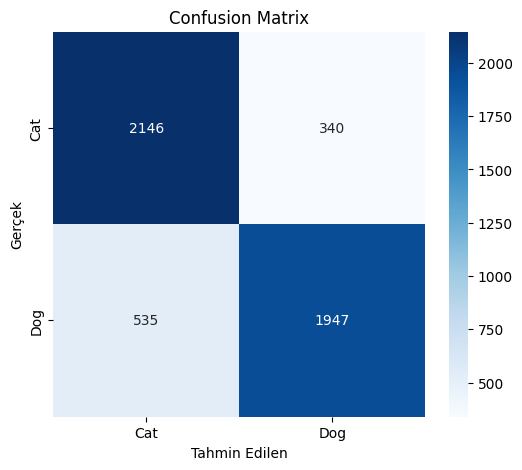


Classification Report:

              precision    recall  f1-score   support

         Cat       0.80      0.86      0.83      2486
         Dog       0.85      0.78      0.82      2482

    accuracy                           0.82      4968
   macro avg       0.83      0.82      0.82      4968
weighted avg       0.83      0.82      0.82      4968



In [7]:
# Confusion Matrix ve Classification Report

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Validation generator'ı sıfırla (baştan başlamak için)
val_generator.reset()

y_true_clean = []
y_pred_classes_clean = []

# Tahminleri alırken bozuk resimleri atlamak için
for i in range(len(val_generator)):
    try:
        x_batch, y_batch = val_generator[i]
        y_pred = model.predict(x_batch, verbose=0)
        y_pred_classes = (y_pred > 0.5).astype(int).reshape(-1)  # binary output için
        y_true_classes = y_batch.reshape(-1)  # binary output
        y_true_clean.extend(y_true_classes)
        y_pred_classes_clean.extend(y_pred_classes)
    except Exception:
        print(f"Bozuk resim atlandı: batch {i}")

# Confusion Matrix oluştur
cm = confusion_matrix(y_true_clean, y_pred_classes_clean)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat','Dog'], yticklabels=['Cat','Dog'])
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true_clean, y_pred_classes_clean, target_names=['Cat','Dog']))


# Güvenli Validation ve Değerlendirme

Validation aşamasında, bozuk veya okunamayan resimlerin model değerlendirmesini etkilememesi için **safe_generator** fonksiyonu kullanılmıştır. Bu sayede sadece geçerli resimler değerlendirmeye dahil edilmiştir.  

- Modelin validation loss ve accuracy değerleri ölçülmüştür.  
- Validation set üzerinde tahminler alınmış ve binary sınıflandırma (Cat vs Dog) için 0.5 eşik değeri kullanılmıştır.  
- Geçerli resimler üzerinden **confusion matrix** ve **classification report** oluşturulmuştur.  

Confusion matrix, modelin her sınıfta ne kadar doğru tahmin yaptığını gösterirken; classification report ise precision, recall ve f1-score değerlerini sunar. Bu yöntemle modelin validation set performansı güvenli ve hatasız bir şekilde değerlendirilmiştir.


157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step - accuracy: 0.8319 - loss: 0.3870
Validation Loss: 0.3938, Validation Accuracy: 0.8258
Bozuk resim atlandı: batch 82


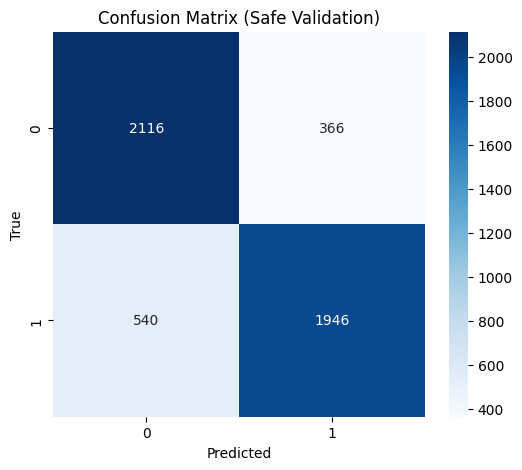


Classification Report:

              precision    recall  f1-score   support

         Cat       0.80      0.85      0.82      2482
         Dog       0.84      0.78      0.81      2486

    accuracy                           0.82      4968
   macro avg       0.82      0.82      0.82      4968
weighted avg       0.82      0.82      0.82      4968



In [9]:
# Güvenli Validation ve Kısa Değerlendirme

# Safe validation için generator oluştur (bozuk resimler atlanır)
val_safe_generator = safe_generator(val_generator)

# Modeli kısa bir değerlendirmeden geçir
val_loss, val_acc = model.evaluate(val_safe_generator, steps=len(val_generator), verbose=1)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

# Validation set üzerinde tahminler al
import numpy as np
y_true_clean = []
y_pred_classes_clean = []

val_generator.reset()
for i in range(len(val_generator)):
    try:
        x_batch, y_batch = val_generator[i]
        y_pred = model.predict(x_batch, verbose=0)
        y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # binary output
        y_true_classes = y_batch.astype(int).flatten()
        y_true_clean.extend(y_true_classes)
        y_pred_classes_clean.extend(y_pred_classes)
    except Exception:
        print(f"Bozuk resim atlandı: batch {i}")

# Confusion matrix ve classification report
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

if len(y_true_clean) > 0:
    cm = confusion_matrix(y_true_clean, y_pred_classes_clean)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Safe Validation)')
    plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_true_clean, y_pred_classes_clean, target_names=['Cat','Dog']))
else:
    print("Uyarı: Geçerli resim bulunamadı. Confusion matrix oluşturulamadı.")

# Hyperparameter Denemesi ve Değerlendirme

Bu bölümde, modelin performansını optimize etmek için farklı optimizer ve learning rate kombinasyonları denenmiştir. Denemeler sırasında:

- **Optimizers:** Adam ve RMSprop  
- **Learning rate:** 0.001 ve 0.0005  

kullanılmıştır. Her kombinasyon için model yeniden oluşturulmuş ve validation set üzerindeki doğruluk (accuracy) ve kayıp (loss) değerleri kaydedilmiştir.  

Sonuçlar, farklı optimizer ve learning rate kombinasyonlarının model performansı üzerindeki etkisini karşılaştırmak için görselleştirilmiştir. Grafikte, her kombinasyonun validation accuracy değeri gösterilmektedir. Bu sayede en iyi performans gösteren hiperparametre kombinasyonu belirlenebilir.



Modeli adam ile eğitiyoruz, LR=0.0010000000474974513


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
485/625 ━━━━━━━━━━━━━━━━━━━━ 30s 218ms/step - accuracy: 0.5726 - loss: 0.7609

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 170s 268ms/step - accuracy: 0.5877 - loss: 0.7339 - val_accuracy: 0.7284 - val_loss: 0.5386
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 150s 240ms/step - accuracy: 0.7432 - loss: 0.5254 - val_accuracy: 0.7798 - val_loss: 0.4630
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 148s 237ms/step - accuracy: 0.7849 - loss: 0.4535 - val_accuracy: 0.8062 - val_loss: 0.4208

Modeli adam ile eğitiyoruz, LR=0.0005000000237487257
Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 153s 240ms/step - accuracy: 0.6111 - loss: 0.6607 - val_accuracy: 0.7498 - val_loss: 0.5113
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 150s 240ms/step - accuracy: 0.7550 - loss: 0.5000 - val_accuracy: 0.7986 - val_loss: 0.4445
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 149s 239ms/step - accuracy: 0.8029 - loss: 0.4324 - val_accuracy: 0.7982 - val_loss: 0.4276

Modeli rmsprop ile eğitiyoruz, LR=0.0010000000474974513
Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 151s 239ms/step - accuracy: 0.5905 - loss: 0.6789 - val_accuracy: 0.6560 -

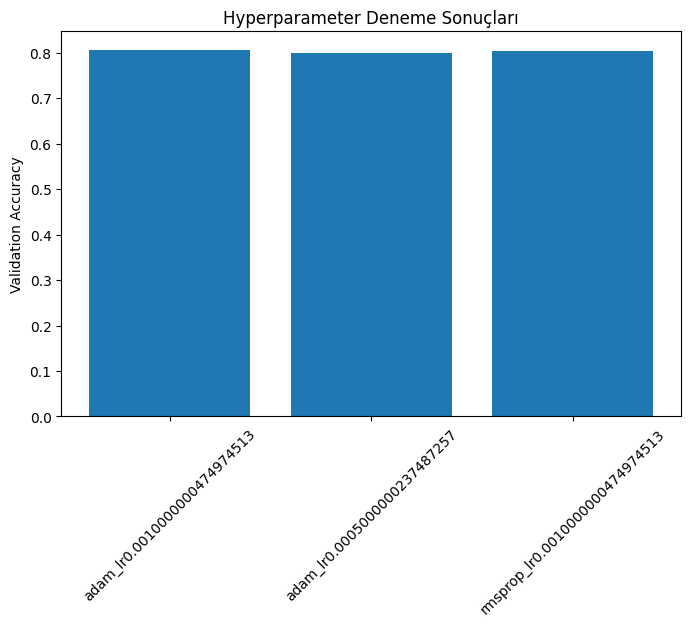

In [10]:
# Hyperparameter Denemesi ve Değerlendirme

from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt

# Farklı optimizer ve learning rate denemesi
optimizers = [
    Adam(learning_rate=0.001),
    Adam(learning_rate=0.0005),
    RMSprop(learning_rate=0.001)
]

# Sonuçları kaydetmek için dictionary
results = {}

for opt in optimizers:
    print(f"\nModeli {opt.get_config()['name']} ile eğitiyoruz, LR={opt.learning_rate.numpy()}")
    
    # Modeli yeniden oluştur (binary classification)
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Eğit
    history = model.fit(
        safe_generator(train_generator),
        validation_data=safe_generator(val_generator),
        steps_per_epoch=len(train_generator),
        validation_steps=len(val_generator),
        epochs=3,  # hızlı test için
        verbose=1
    )
    
    # Son epoch sonuçlarını kaydet
    val_acc = history.history['val_accuracy'][-1]
    val_loss = history.history['val_loss'][-1]
    results[opt.get_config()['name'] + f"_lr{opt.learning_rate.numpy()}"] = (val_acc, val_loss)

# Sonuçları yazdır
print("\nHyperparameter Deneme Sonuçları:")
for k, v in results.items():
    print(f"{k}: Validation Accuracy={v[0]:.4f}, Validation Loss={v[1]:.4f}")

# Grafikleri çiz
plt.figure(figsize=(8,5))
plt.bar(results.keys(), [v[0] for v in results.values()])
plt.xticks(rotation=45)
plt.ylabel("Validation Accuracy")
plt.title("Hyperparameter Deneme Sonuçları")
plt.show()

**Not:** Grad-CAM / Eigen-CAM görselleştirmesi, çeşitli denemelere rağmen teknik nedenlerden dolayı gerçekleştirilemedi. Bunun nedeni büyük olasılıkla kullanılan görsellerin formatları veya Kaggle ortamındaki kısıtlamalardı. Bu nedenle bu aşama uygulanamamıştır.

**Not:** Model kaydetme ve yükleme kısmı da uygulanmamıştır. Yine de model eğitilmiş ve validation set üzerindeki performansı değerlendirilmiştir. Confusion matrix ve accuracy/loss grafikleri ile modelin başarı durumu raporlanmıştır.